In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 化学ポテンシャル

In [2]:
from scipy.integrate import quad
def f(e, mu, beta):
    return np.sqrt(e)*(1-np.tanh(beta*(e-mu)/2))/2
def density(mu, beta):
    return 1.5*quad(f, 0, np.infty, args=(mu, beta))[0] - 1
def bisect(f, x0, x1, args, maxiter=100):
    y0, y1 = f(x0, *args), f(x1, *args)  # *args でタプルを展開
    for i in range(maxiter):
        xM = (x0 + x1)/2
        yM = f(xM, *args)
        if y0 * yM > 0: x0 = xM
        else: x1 = xM
        if abs(yM) < 1e-6: break # 誤差の閾値を1e-6に指定
    return xM, yM

kBTs = np.linspace(1e-9, 0.3, 31)
# T=0でbetaが定義されないため1e-9からスタートしている
num = [bisect(density, -2, 2, (1/kBT,))[0] for kBT in kBTs]

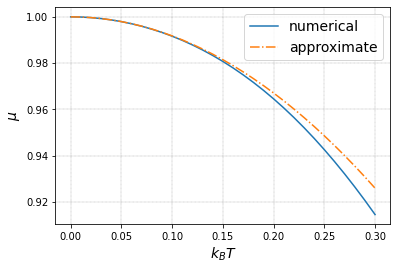

In [5]:
app = 1-np.pi**2/12*kBTs**2
plt.plot(kBTs, num, label='numerical')
plt.plot(kBTs, app, label='approximate', linestyle='-.')
plt.xlabel("$k_BT$", fontsize=14)
plt.ylabel("$\mu$", fontsize=14)
plt.legend(fontsize=14)
plt.grid(color='black', linestyle='dotted', linewidth=0.3)
plt.show()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/PythonText_Figures


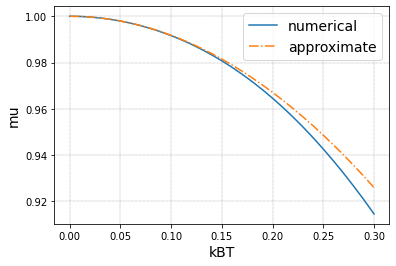

In [ ]:
# 図の保存用(テキストには含まれない)
plt.plot(kBTs, num, label='numerical')
plt.plot(kBTs, app, label='approximate', linestyle='-.')
plt.xlabel("kBT", fontsize=14)
plt.ylabel("mu", fontsize=14)
plt.legend(fontsize=14)
plt.grid(color='black', linestyle='dotted', linewidth=0.3)
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/PythonText_Figures
plt.savefig("figure_bisect_mu.pdf", bbox_inches='tight')

# 1次元ハイゼンベルグ模型のベーテ仮説方程式

In [ ]:
from scipy.optimize import root
theta = lambda x, n: np.arctan(x/n)/np.pi
def bethe(x, N, M):
    z1, z2 = theta(x, 1), theta(x[:,None] - x[None,:],2)
    z2 = np.sum(z2, axis=1)/N
    z3 = np.linspace(-(M-1)/2,(M-1)/2,M)/N
    return z1-z2-z3  # 問題文の左辺の値を返す
N = 100
sol = root(bethe, x0=np.random.rand(N//2), args=(N, N//2))
energy = lambda x: 2/(1+x**2)
E = -np.sum(energy(sol.x))/N + 1/4

# 超伝導の平均場理論

In [ ]:
from scipy.integrate import quad
def rhs_sc(delta, lam, ome, beta):
    def func(x, delta, beta):
        E = np.sqrt(x**2 + delta**2)
        return delta*np.tanh(beta*E/2)/E
    return lam * quad(func, 0, ome, args=(delta, beta))[0]

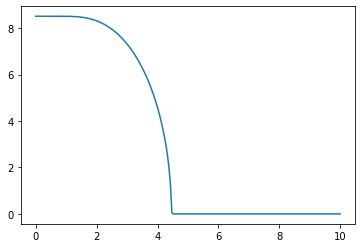

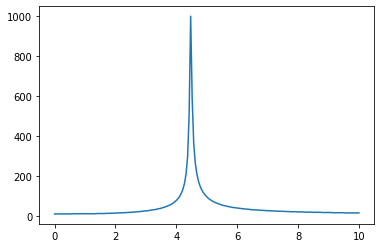

In [ ]:
lam, ome, Ts = 1, 10, np.linspace(1e-6,10,200)
ans = []
for T in Ts:  # それぞれの温度で秩序パラメータを計算
    beta, d0  = 1/T, 1.0
    for i in range(1000):  # 収束するまで最大1000回ループ
        d1 = rhs_sc(d0, lam, ome, beta)
        if abs(d1-d0) < 1e-5: break  # 収束チェック
        d0 = d1
    ans.append([d0, abs(d1-d0), i])
ans = np.array(ans)
plt.plot(Ts, ans[:,0])  # 秩序パラメータの温度依存性をプロット
plt.show()
plt.plot(Ts, ans[:,2])  # 収束に必要だった反復回数のプロット
plt.show()

# 発展問題(化学ポテンシャル)

In [ ]:
def df(x1, x2):
    f1 = np.exp(x1) + x1*x2 - 1
    f2 = np.sin(x1*x2) + x1 + x2
    return np.array([f1, f2])
def jac(x1, x2):
    f11, f22 = np.exp(x1) + x2, x1*np.cos(x1*x2) + 1
    f12, f21 = x1, x2*np.cos(x1*x2) + 1
    return np.array([[f11,f12],[f21,f22]])

In [ ]:
norm = np.linalg.norm   # ただの再定義で本質的ではない
def r_N(df, jac, x0):
    return - np.linalg.solve(jac(*x0), df(*x0))
def r_S(df, jac, x0):
    r = -jac(*x0)@df(*x0)
    alpha = norm(r)**2/(norm(jac(*x0)@r)**2)
    return alpha*r # alphaをr_Sの定義に加えている点に注意

In [ ]:
def powell(df, jac, x0, method="P", delta=1, maxitr=200):
    # method="N", "S", "P"でそれぞれの手法を選択する。
    # deltaはパウエル混合法で用いる信頼領域の半径。
    x = [x0]
    for _ in range(maxitr):
        if method=="N": x1 = x0 + r_N(df, jac, x0)
        elif method=="S": x1 = x0 + r_S(df, jac, x0)
        elif method=="P":
            rN, rS = r_N(df, jac, x0), r_S(df, jac, x0)
            if   norm(rN)<= delta: x1 = x0 + rN
            elif norm(rS)>=delta: x1 = x0 + delta*rS/norm(rS)
            else:
                a, b = norm(rN-rS)**2, np.dot(rS, rN-rS)
                c = norm(rS)**2 - delta**2
                s = (-b+np.sqrt(b**2-a*c))/a
                x1 = x0+rS+s*(rN-rS)
        if norm(x1-x0) < 1e-12: break
        x0 = x1
        x.append(x0)
    return np.array(x)

In [ ]:
xN = powell(df, jac, np.array([-3, 4]), "N").T
print(xN[0,-1],xN[1,-1],xN.shape[1])

-2.2910235449209726e-13 -2.851085358122904e-13 28


In [ ]:
x0 = np.array([-3, 6])
xN = powell(df, jac, x0, "N").T
xS = powell(df, jac, x0, "S").T
xP = powell(df, jac, x0, "P").T
print(xN[0,-1],xN[1,-1],xN.shape[1])
print(xS[0,-1],xS[1,-1],xS.shape[1])
print(xP[0,-1],xP[1,-1],xP.shape[1])

nan nan 201
1.8959355293360254e-14 -2.7261689185854866e-14 45
5.719353066637349e-18 -5.7190140582955215e-18 14


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


# 発展問題(超伝導の平均場理論)

In [ ]:
# テキストには含まれない
from scipy.integrate import quad
def rhs_sc(delta, lam, ome, beta):
    def func(x, delta, beta):
        E = np.sqrt(x**2 + delta**2)
        return delta*np.tanh(beta*E/2)/E
    return lam * quad(func, 0, ome, args=(delta, beta))[0]

In [ ]:
ans = []
for T in Ts:
    beta, d0  = 1/T, 10.0
    for i in range(10):
        d1 = rhs_sc(d0, lam, ome, beta)
        d2 = rhs_sc(d1, lam, ome, beta)
        nd = d0 - (d1-d0)**2/(d0-2*d1+d2)
        if abs(nd-d0) < 1e-5: break
        d0 = nd
    ans.append([d0, abs(nd-d0), 2*i])
ans = np.array(ans)

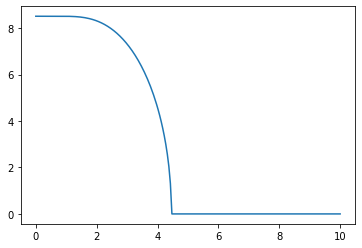

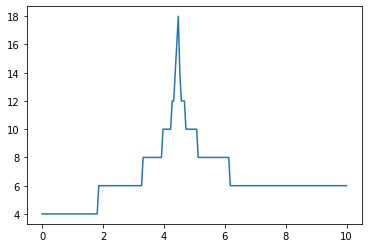

In [ ]:
# テキストには含まれない
plt.plot(Ts, ans.T[0])
plt.show()
plt.plot(Ts, ans.T[2])
plt.show()